## Introduction

This notebook provide an overview of the methodology of the paper [One-step Diffusion with Distribution Matching Distillation](https://arxiv.org/abs/2311.18828).

## Training

For the distillation part, we require a paired dataset of images and latents (and optionally class labels for class-conditioning). Here, we focus on class conditional training of the model, $G_\theta$. The overall pipeline has 3 main components:

### Feed signals from a critic

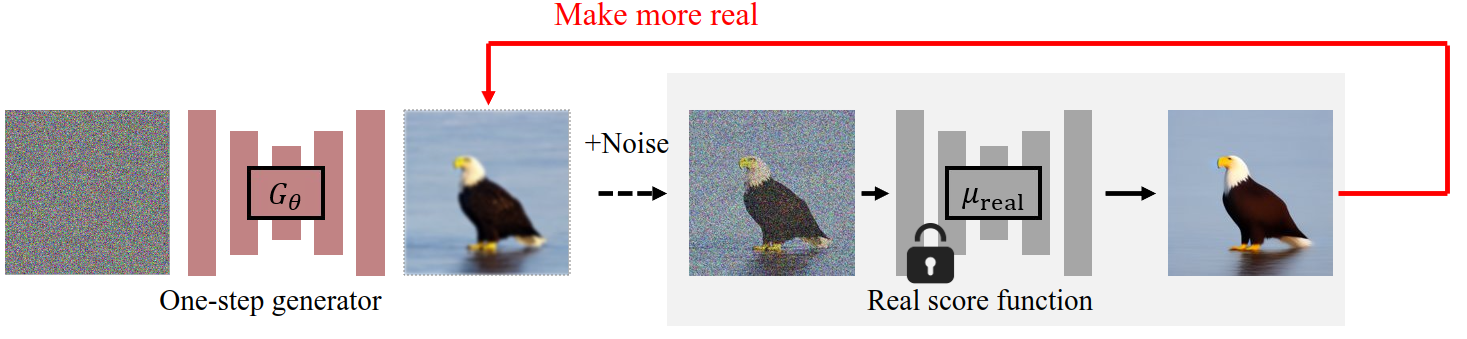

Here the objective is to train the model given noise to be fed by signals from a critic, $\mu_{real}$, (frozen) to make the image more realistic. Here, the generator produces a sample, and after a stochastic diffusion process (random timestep), the generator is optimized from the signal from critic's denoised output to get close to more "real". 

### Feed signals from two critics

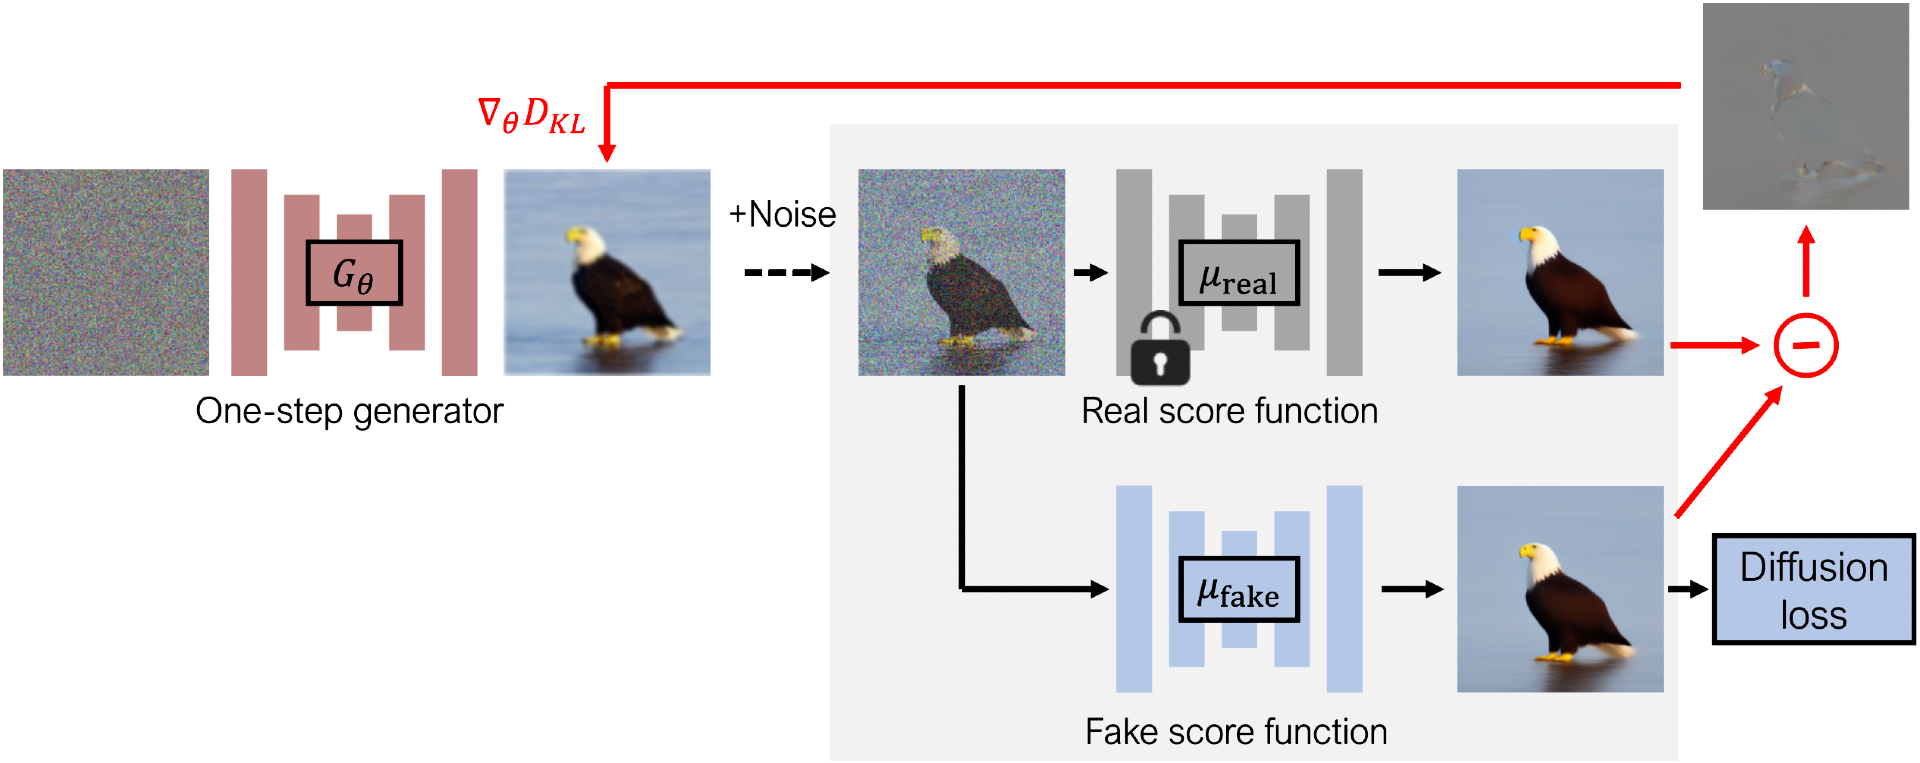

Feeding signals only from a frozen critic, $\mu_{real}$ (teacher) is hard to optimize, and it suffers from mode collapse. The paper introduced another critic $\mu_{fake}$ that is continually trained with a diffusion loss. First, a sample is obtained from the generator, and forward diffusion is applied on the output. After the forward diffusion process, the noisy sample is given to $\mu_{real}$ and $\mu_{fake}$ and denoised versions of the noisy sample are obtained. The difference between the outputs is used to feed the generator, $G_\theta$.


### Regression Loss

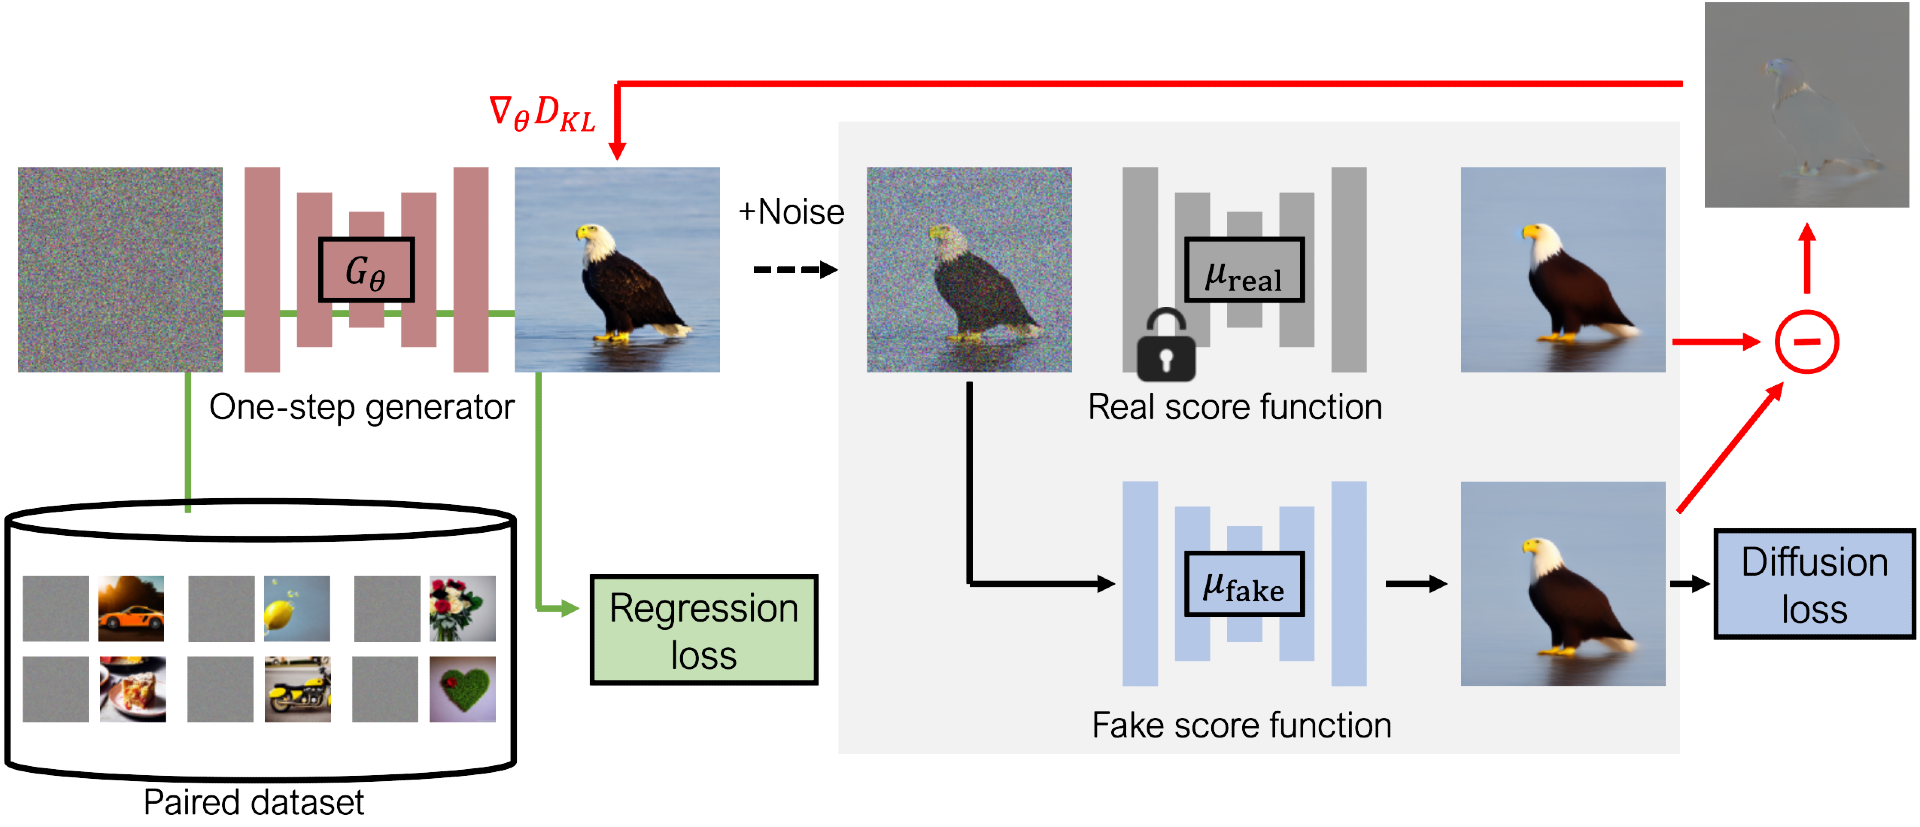

The final component of the training pipeline is the regression loss. The paper also proposed to use a regression loss between output of $G_\theta$ given the latent from latent-image pairs to the image to better guide the $G_\theta$ to match the distribution of the base model, and the authors still observed mode collapse on feeding signals from two critics (step 2).


## Training Pipeline

Covering the main components of the training, we first need a teacher model. [EDM](https://arxiv.org/abs/2206.00364) is used as the base model, $\mu_{base}$ in the paper for CIFAR and ImageNet datasets. Here, we will use CIFAR-10 dataset and the EDM class-conditioned model as a teacher. Also, the paper utilized the same base model architecture and weights for all three models, $G_\theta$, $\mu_{real}$ and $\mu_{fake}$. However, we aim to train a one-step model unlike diffusion models that generates samples in several steps, and hence with time conditioning. The authors proposed to fix the timestep for the one-step generator model, $G_\theta$ as $G_\theta(z) = \mu_{base}(z, T-1)$, where in practice $T=1000$ in the experiments.

We specifically use [edm-cifar10-32x32-cond-vp.pkl](https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-cond-vp.pkl) as the base model which was used in the paper for conditional training on CIFAR-10.

After selecting the teacher/base model, we now require a synthetic dataset (latent-image pairs) from the base model. In the experiments we created a latent-image pairs dataset of size 100 K with class labels. The dataset can be reached from [devrim/dmd_cifar10_edm_distillation_dataset](https://huggingface.co/datasets/Devrim/dmd_cifar10_edm_distillation_dataset/tree/main). Particularly we will use the toy dataset that is a subset from the 100 K generated synthetic dataset of 100 samples of the same class (0/airplane) throughout the notebook for convenience.

## Dataset Samples

Here the image displaying 10 random images (left) from the real CIFAR-10 dataset, and (right) from the synthetic dataset formed by sampling from the conditional pretrained EDM (base) model on CIFAR-10.

<center><img src="assets/dataset_samples.png"></center>

In [1]:
"""Sets up the toy test set for FID evaluation (on toy sets). Toy sets are airplane only (`c=0`) and have the size of 100 instances."""

from pathlib import Path

import PIL.Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms


class CIFAR10Toy(Dataset):
    def __init__(self, data_path: str):
        self.data_path = Path(data_path)
        self.transform = transforms.ToTensor()

    def __len__(self):
        return 100

    def __getitem__(self, index):
        img = self.transform(PIL.Image.open(self.data_path / f"im_{index}.png"))
        c = torch.tensor(0)
        return img, c


def create_toy_testset(data_path: str):
    data_path = Path(data_path)
    data_path.mkdir(exist_ok=True)
    test_dataset = CIFAR10(
        root=DATA_DIR, train=False, download=True,
    )
    n = 0
    for (img, c) in test_dataset:
        if c != 0:
            continue
        img.save(data_path / f"im_{n}.png")
        n += 1
        if n == 100:
            break

/home/devrim/anaconda3/envs/dmd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/devrim/anaconda3/envs/dmd/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/devrim/anaconda3/envs/dmd/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104warnERKNS_7WarningE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Download the dataset
# Run `bash scripts/download_data.sh`, optionally you can only download toy dataset.

In [71]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torchvision.datasets import CIFAR10

from dmd import DATA_DIR, OUTPUTS_DIR
from dmd.modeling_utils import get_fixed_generator_sigma, sample_from_generator, load_edm
from dmd.utils.common import image_grid
from dmd.utils.logging import CheckpointHandler
from dmd.dataset.cifar_pairs import CIFARPairs
from dmd.loss import GeneratorLoss, DenoisingLoss

In [4]:
# Constants

BASE_MODEL = "https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-cond-vp.pkl"
N_DATASET = 100  # Toy dataset size
DEVICE = torch.device("cuda")  # Change this accordingly
DATA_PATH = DATA_DIR / "distillation_dataset_h5/cifar_toy.hdf5"  # For convenience we use toy dataset, but feel free to change it to the training dataset.
TEST_DATA_PATH = DATA_DIR / "cifar-10-toy-airplane"  # this will be created at dataset generation
OUTPUT_DIR = OUTPUTS_DIR / "toy_test"  # Output directory for saving the model and artifacts.
EPOCHS = 40
BATCH_SIZE = 4
NUM_WORKERS = 10
LR = 6e-6
WEIGHT_DECAY = 0.01
BETAS = (0.9, 0.999)
DMD_LOSS_TIMESTEP = 1000  # value `T`, for discretizing timesteps (e.g. binsize)
DMD_LAMBDA_REG = 0.25  # weight of the regression loss in the combined loss
MAX_NORM = 10.0  # gradient clipping
IM_SAVE_STEPS = int(0.51 * N_DATASET/BATCH_SIZE)  # At what percent of the epoch images should be saved
PRINT_STEPS = int(0.34 * N_DATASET/BATCH_SIZE)  # At what percent of the epoch loss metrics should be printed

In [5]:
# Dataset setup

training_dataset = CIFARPairs(DATA_PATH)
train_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

create_toy_testset(TEST_DATA_PATH)  # create toy dataset to match our toy dataset (airplane only and size=100)
test_dataset = CIFAR10Toy(TEST_DATA_PATH)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=NUM_WORKERS)

Files already downloaded and verified


In [6]:
# Training Setup

# Set up the teacher and student models all models are instatiated from the same base model
mu_real = load_edm(model_path=BASE_MODEL, device=DEVICE)
mu_fake = load_edm(model_path=BASE_MODEL, device=DEVICE)
generator = load_edm(model_path=BASE_MODEL, device=DEVICE)

# Create losses, Generator Loss is the combined loss of DMD and the regression loss (LPIPS)
generator_loss = GeneratorLoss(timesteps=DMD_LOSS_TIMESTEP, lambda_reg=DMD_LAMBDA_REG)
diffusion_loss = DenoisingLoss()

# Create optimizers
generator_optimizer = AdamW(params=generator.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, betas=BETAS)
diffuser_optimizer = AdamW(params=mu_fake.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, betas=BETAS)

# Create ckp handler
checkpoint_handler = CheckpointHandler(
        checkpoint_dir=OUTPUT_DIR, lower_is_better=True
    )  # hardcoded lower_is_better for experimentation

/home/devrim/anaconda3/envs/dmd/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/devrim/anaconda3/envs/dmd/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/devrim/anaconda3/envs/dmd/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training Loop

For convenience we will use the helper functions from the sourcecode, and for more detail please check the codebase. Here, we will only slightly give an overview of the crucial parts of the training loop discarding the auxiliary stuff like distributed setup, logging, model saving, lr scheduling, etc. Also, we will use the function and classes with the same name as implemented in the codebase. The pseudo-codeish training loop is as follows:


**Algorithm**

**Input**: pretrained base model `mu_real`, paired dataset `D = {z_ref, y_ref, class_id}` \
**Output**: Trained one-step generator `generator`

```
generator = copy_weights(mu_real)
mu_fake = copy_weights(mu_real)

# Note: `generator` is currently a diffusion model, but we need one-step generator, and hence a time independent model. To do this, the paper fixes a sigma_t and use this sigma for the `generator` in both training and evaluation, we will call this constant `g_sigma`. In short and abuse of notation `G(z) = generator(z, sigma=sigma_t)`. This choice (having a large `t`) is intuitively logical as in diffusion models, it's expected that at the furthest stages of forward diffusion, the input is assumed to be converged in distribution to N(0,1).
# Note-2: EDM Models (Karras et al., 2022) are implemented and designed in a way that they take `sigma_t` in the forward method, that is the sigma at the t'th position (discretized). Also, EDM Models (Karras et al., 2022) noise scheduling is different from other diffusion models (e.g. DDPM). 
g_sigma = get_sigmas_karras(t=1000, sigma_min=0.002, sigma_max=80, rho=7.0, device=device)[1000-1]  # Get (T-1)^th sigma. `T=1000` in practice.

# Set generator and mu_fake to train mode, mu_real is frozen
generator.requires_grad_(True).train()
mu_fake.requires_grad_(True).train()
mu_real.requires_grad_(False).eval()

for epoch in range(epochs):
    for (z_ref, y_ref, class_ids) in train_loader:  # all tensors in the preset `device` (e.g. GPU)
        # Generate images from generator
        z = torch.randn_like(y_ref)  # generate random noise from N(0,1) as the same shape of `y_ref` (B,C,H,w)
    
        # Scale z and z_ref with sigma(T-1), see `Note-2`.
        z = z * g_sigma
        z_ref = z_ref * g_sigma  # `z_ref` is the paired latent for `y_ref`
        class_labels = encode_labels(class_ids)  # one-hot encoding
        
        # Update generator (Combined Loss: DMD Loss + Regression Loss)
        x = generator(z, g_sigma, class_labels)
        x_ref = generator(z_ref, g_sigma, class_labels)
    
        # DMD Loss: (mu_real, mu_fake, x, class_labels) and LPIPS: (x_ref, y_ref)
        loss_g = generator_loss(mu_real, mu_fake, x, x_ref, y_ref, class_labels)
        update_parameters(generator, loss_g, generator_optimizer, max_norm)  # update `generator` with gradient clipping at `max_norm`
    
        # Update mu_fake (Denoising loss)
        t = torch.randint(1, 1000, [x.shape[0]])  # `t=0` leads to inf in our implementation, and hence we start from 1
        loss_d = diffusion_loss(mu_fake, x, t, class_labels)
        update_parameters(mu_fake, loss_d, diffusion_optimizer, max_norm)  # update `mu_fake` with gradient clipping at `max_norm`
```


In [7]:
from dmd.train import train

In [9]:
# start training
train(
    generator=generator,
    mu_real=mu_real,
    mu_fake=mu_fake,
    data_loader_train=train_loader,
    data_loader_test=test_loader,
    device=DEVICE,
    loss_g=generator_loss,
    loss_d=diffusion_loss,
    optimizer_g=generator_optimizer,
    optimizer_d=diffuser_optimizer,
    epochs=EPOCHS,
    neptune_run=None,
    cudnn_benchmark=True,
    amp_autocast=None,
    max_norm=MAX_NORM,
    print_freq=PRINT_STEPS,
    im_save_freq=IM_SAVE_STEPS,
    checkpoint_handler=checkpoint_handler,
)

Start training for 40 epochs
Epoch: [0]  [ 0/25]  eta: 0:00:26  loss_g: 0.2000 (0.2000)  loss_d: 0.6103 (0.6103)  time: 1.0638  data: 0.3915  max mem: 4191
Epoch: [0]  [ 8/25]  eta: 0:00:09  loss_g: 0.1999 (0.2001)  loss_d: 0.4000 (0.3438)  time: 0.5804  data: 0.0454  max mem: 4191
Epoch: [0]  [16/25]  eta: 0:00:05  loss_g: 0.1979 (0.1975)  loss_d: 0.4000 (0.3646)  time: 0.5609  data: 0.0242  max mem: 4191
Epoch: [0]  [24/25]  eta: 0:00:00  loss_g: 0.1945 (0.1953)  loss_d: 0.2319 (0.3714)  time: 0.5418  data: 0.0011  max mem: 4191
Epoch: [0] Total time: 0:00:14 (0.5635 s / it)
Averaged stats: loss_g: 0.1945 (0.1953)  loss_d: 0.2319 (0.3714)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 15.69it/s]


Test FID: 295.1718344388818
Epoch: [1]  [ 0/25]  eta: 0:00:26  loss_g: 0.2008 (0.2008)  loss_d: 0.6522 (0.6522)  time: 1.0407  data: 0.3661  max mem: 4191
Epoch: [1]  [ 8/25]  eta: 0:00:10  loss_g: 0.1956 (0.1962)  loss_d: 0.4109 (0.3326)  time: 0.6012  data: 0.0433  max mem: 4191
Epoch: [1]  [16/25]  eta: 0:00:05  loss_g: 0.1946 (0.1936)  loss_d: 0.3810 (0.3268)  time: 0.5773  data: 0.0229  max mem: 4191
Epoch: [1]  [24/25]  eta: 0:00:00  loss_g: 0.1946 (0.1924)  loss_d: 0.3711 (0.3423)  time: 0.5522  data: 0.0012  max mem: 4191
Epoch: [1] Total time: 0:00:14 (0.5779 s / it)
Averaged stats: loss_g: 0.1946 (0.1924)  loss_d: 0.3711 (0.3423)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.28it/s]


Test FID: 257.35099872091996
Epoch: [2]  [ 0/25]  eta: 0:00:28  loss_g: 0.2112 (0.2112)  loss_d: 0.6205 (0.6205)  time: 1.1584  data: 0.4478  max mem: 4191
Epoch: [2]  [ 8/25]  eta: 0:00:10  loss_g: 0.1912 (0.1934)  loss_d: 0.3114 (0.3199)  time: 0.6173  data: 0.0519  max mem: 4191
Epoch: [2]  [16/25]  eta: 0:00:05  loss_g: 0.1929 (0.1966)  loss_d: 0.2637 (0.2789)  time: 0.5782  data: 0.0277  max mem: 4191
Epoch: [2]  [24/25]  eta: 0:00:00  loss_g: 0.1919 (0.1953)  loss_d: 0.1078 (0.2365)  time: 0.5376  data: 0.0008  max mem: 4191
Epoch: [2] Total time: 0:00:14 (0.5687 s / it)
Averaged stats: loss_g: 0.1919 (0.1953)  loss_d: 0.1078 (0.2365)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 13.78it/s]


Test FID: 234.15436813492627
Epoch: [3]  [ 0/25]  eta: 0:00:27  loss_g: 0.1839 (0.1839)  loss_d: 0.3932 (0.3932)  time: 1.0875  data: 0.3891  max mem: 4191
Epoch: [3]  [ 8/25]  eta: 0:00:10  loss_g: 0.1906 (0.1962)  loss_d: 0.3452 (0.2726)  time: 0.6431  data: 0.0463  max mem: 4191
Epoch: [3]  [16/25]  eta: 0:00:05  loss_g: 0.1877 (0.1922)  loss_d: 0.1507 (0.2310)  time: 0.6197  data: 0.0247  max mem: 4191
Epoch: [3]  [24/25]  eta: 0:00:00  loss_g: 0.1906 (0.1932)  loss_d: 0.1015 (0.2305)  time: 0.5888  data: 0.0012  max mem: 4191
Epoch: [3] Total time: 0:00:15 (0.6097 s / it)
Averaged stats: loss_g: 0.1906 (0.1932)  loss_d: 0.1015 (0.2305)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.65it/s]


Test FID: 221.50450634370736
Epoch: [4]  [ 0/25]  eta: 0:00:27  loss_g: 0.2004 (0.2004)  loss_d: 0.0591 (0.0591)  time: 1.0962  data: 0.4122  max mem: 4191
Epoch: [4]  [ 8/25]  eta: 0:00:10  loss_g: 0.1924 (0.1959)  loss_d: 0.1690 (0.2076)  time: 0.5920  data: 0.0478  max mem: 4191
Epoch: [4]  [16/25]  eta: 0:00:05  loss_g: 0.1902 (0.1951)  loss_d: 0.1690 (0.2191)  time: 0.5842  data: 0.0255  max mem: 4191
Epoch: [4]  [24/25]  eta: 0:00:00  loss_g: 0.1893 (0.1966)  loss_d: 0.1118 (0.1991)  time: 0.5561  data: 0.0005  max mem: 4191
Epoch: [4] Total time: 0:00:14 (0.5796 s / it)
Averaged stats: loss_g: 0.1893 (0.1966)  loss_d: 0.1118 (0.1991)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:01<00:00, 12.86it/s]


Test FID: 215.27267940941096
Epoch: [5]  [ 0/25]  eta: 0:00:26  loss_g: 0.2029 (0.2029)  loss_d: 0.1905 (0.1905)  time: 1.0767  data: 0.4193  max mem: 4191
Epoch: [5]  [ 8/25]  eta: 0:00:09  loss_g: 0.1934 (0.1892)  loss_d: 0.1104 (0.1946)  time: 0.5867  data: 0.0485  max mem: 4191
Epoch: [5]  [16/25]  eta: 0:00:05  loss_g: 0.1959 (0.1963)  loss_d: 0.1364 (0.1984)  time: 0.5630  data: 0.0259  max mem: 4191
Epoch: [5]  [24/25]  eta: 0:00:00  loss_g: 0.1965 (0.1964)  loss_d: 0.1156 (0.1924)  time: 0.5345  data: 0.0007  max mem: 4191
Epoch: [5] Total time: 0:00:13 (0.5595 s / it)
Averaged stats: loss_g: 0.1965 (0.1964)  loss_d: 0.1156 (0.1924)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 13.45it/s]


Test FID: 211.24542527084205
Epoch: [6]  [ 0/25]  eta: 0:00:27  loss_g: 0.2345 (0.2345)  loss_d: 0.0744 (0.0744)  time: 1.0849  data: 0.3223  max mem: 4191
Epoch: [6]  [ 8/25]  eta: 0:00:11  loss_g: 0.1935 (0.2034)  loss_d: 0.1035 (0.1769)  time: 0.6737  data: 0.0384  max mem: 4191
Epoch: [6]  [16/25]  eta: 0:00:05  loss_g: 0.1948 (0.2036)  loss_d: 0.1035 (0.1852)  time: 0.6531  data: 0.0205  max mem: 4191
Epoch: [6]  [24/25]  eta: 0:00:00  loss_g: 0.1982 (0.2057)  loss_d: 0.0825 (0.1652)  time: 0.6280  data: 0.0010  max mem: 4191
Epoch: [6] Total time: 0:00:16 (0.6501 s / it)
Averaged stats: loss_g: 0.1982 (0.2057)  loss_d: 0.0825 (0.1652)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:01<00:00, 13.00it/s]


Test FID: 206.17307013545022
Epoch: [7]  [ 0/25]  eta: 0:00:28  loss_g: 0.2236 (0.2236)  loss_d: 0.2820 (0.2820)  time: 1.1383  data: 0.4380  max mem: 4191
Epoch: [7]  [ 8/25]  eta: 0:00:11  loss_g: 0.2049 (0.2129)  loss_d: 0.2806 (0.2448)  time: 0.6782  data: 0.0498  max mem: 4191
Epoch: [7]  [16/25]  eta: 0:00:05  loss_g: 0.2075 (0.2110)  loss_d: 0.2064 (0.1925)  time: 0.6641  data: 0.0267  max mem: 4191
Epoch: [7]  [24/25]  eta: 0:00:00  loss_g: 0.2118 (0.2151)  loss_d: 0.0940 (0.1734)  time: 0.6440  data: 0.0012  max mem: 4191
Epoch: [7] Total time: 0:00:16 (0.6652 s / it)
Averaged stats: loss_g: 0.2118 (0.2151)  loss_d: 0.0940 (0.1734)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.16it/s]


Test FID: 203.63894987244282
Epoch: [8]  [ 0/25]  eta: 0:00:30  loss_g: 0.2143 (0.2143)  loss_d: 0.0619 (0.0619)  time: 1.2336  data: 0.4148  max mem: 4191
Epoch: [8]  [ 8/25]  eta: 0:00:11  loss_g: 0.2235 (0.2197)  loss_d: 0.0683 (0.1541)  time: 0.6544  data: 0.0478  max mem: 4191
Epoch: [8]  [16/25]  eta: 0:00:05  loss_g: 0.2235 (0.2215)  loss_d: 0.0937 (0.1590)  time: 0.6099  data: 0.0256  max mem: 4191
Epoch: [8]  [24/25]  eta: 0:00:00  loss_g: 0.2292 (0.2273)  loss_d: 0.0959 (0.1570)  time: 0.5738  data: 0.0008  max mem: 4191
Epoch: [8] Total time: 0:00:15 (0.6111 s / it)
Averaged stats: loss_g: 0.2292 (0.2273)  loss_d: 0.0959 (0.1570)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 15.40it/s]


Test FID: 198.21282572005953
Epoch: [9]  [ 0/25]  eta: 0:00:28  loss_g: 0.2101 (0.2101)  loss_d: 0.3113 (0.3113)  time: 1.1401  data: 0.4670  max mem: 4191
Epoch: [9]  [ 8/25]  eta: 0:00:10  loss_g: 0.2255 (0.2310)  loss_d: 0.0848 (0.1317)  time: 0.5985  data: 0.0526  max mem: 4191
Epoch: [9]  [16/25]  eta: 0:00:05  loss_g: 0.2353 (0.2382)  loss_d: 0.0956 (0.1278)  time: 0.5861  data: 0.0280  max mem: 4191
Epoch: [9]  [24/25]  eta: 0:00:00  loss_g: 0.2387 (0.2392)  loss_d: 0.1478 (0.1516)  time: 0.5719  data: 0.0010  max mem: 4191
Epoch: [9] Total time: 0:00:14 (0.5939 s / it)
Averaged stats: loss_g: 0.2387 (0.2392)  loss_d: 0.1478 (0.1516)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.09it/s]


Test FID: 198.66419371060314
Epoch: [10]  [ 0/25]  eta: 0:00:27  loss_g: 0.2491 (0.2491)  loss_d: 0.0547 (0.0547)  time: 1.1008  data: 0.4026  max mem: 4191
Epoch: [10]  [ 8/25]  eta: 0:00:10  loss_g: 0.2491 (0.2441)  loss_d: 0.1557 (0.1662)  time: 0.6393  data: 0.0468  max mem: 4191
Epoch: [10]  [16/25]  eta: 0:00:05  loss_g: 0.2575 (0.2536)  loss_d: 0.1557 (0.1919)  time: 0.6032  data: 0.0248  max mem: 4191
Epoch: [10]  [24/25]  eta: 0:00:00  loss_g: 0.2606 (0.2539)  loss_d: 0.1389 (0.1739)  time: 0.5847  data: 0.0008  max mem: 4191
Epoch: [10] Total time: 0:00:15 (0.6098 s / it)
Averaged stats: loss_g: 0.2606 (0.2539)  loss_d: 0.1389 (0.1739)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 13.60it/s]


Test FID: 193.2187014158435
Epoch: [11]  [ 0/25]  eta: 0:00:30  loss_g: 0.2406 (0.2406)  loss_d: 0.0955 (0.0955)  time: 1.2162  data: 0.4474  max mem: 4191
Epoch: [11]  [ 8/25]  eta: 0:00:10  loss_g: 0.2575 (0.2549)  loss_d: 0.0955 (0.1463)  time: 0.6232  data: 0.0509  max mem: 4191
Epoch: [11]  [16/25]  eta: 0:00:05  loss_g: 0.2439 (0.2458)  loss_d: 0.0955 (0.1380)  time: 0.5936  data: 0.0271  max mem: 4191
Epoch: [11]  [24/25]  eta: 0:00:00  loss_g: 0.2383 (0.2481)  loss_d: 0.0975 (0.1568)  time: 0.5544  data: 0.0007  max mem: 4191
Epoch: [11] Total time: 0:00:14 (0.5891 s / it)
Averaged stats: loss_g: 0.2383 (0.2481)  loss_d: 0.0975 (0.1568)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.55it/s]


Test FID: 193.37191282308024
Epoch: [12]  [ 0/25]  eta: 0:00:27  loss_g: 0.2908 (0.2908)  loss_d: 0.1118 (0.1118)  time: 1.0909  data: 0.3922  max mem: 4191
Epoch: [12]  [ 8/25]  eta: 0:00:10  loss_g: 0.2571 (0.2683)  loss_d: 0.2743 (0.2009)  time: 0.5978  data: 0.0461  max mem: 4191
Epoch: [12]  [16/25]  eta: 0:00:05  loss_g: 0.2571 (0.2754)  loss_d: 0.1866 (0.2094)  time: 0.5670  data: 0.0244  max mem: 4191
Epoch: [12]  [24/25]  eta: 0:00:00  loss_g: 0.2571 (0.2806)  loss_d: 0.1724 (0.1924)  time: 0.5310  data: 0.0010  max mem: 4191
Epoch: [12] Total time: 0:00:14 (0.5602 s / it)
Averaged stats: loss_g: 0.2571 (0.2806)  loss_d: 0.1724 (0.1924)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 13.67it/s]


Test FID: 189.22813185362503
Epoch: [13]  [ 0/25]  eta: 0:00:25  loss_g: 0.2929 (0.2929)  loss_d: 0.3692 (0.3692)  time: 1.0195  data: 0.3646  max mem: 4191
Epoch: [13]  [ 8/25]  eta: 0:00:10  loss_g: 0.2530 (0.2553)  loss_d: 0.0917 (0.1401)  time: 0.5911  data: 0.0429  max mem: 4191
Epoch: [13]  [16/25]  eta: 0:00:05  loss_g: 0.2530 (0.2582)  loss_d: 0.0887 (0.1232)  time: 0.5717  data: 0.0229  max mem: 4191
Epoch: [13]  [24/25]  eta: 0:00:00  loss_g: 0.2626 (0.2678)  loss_d: 0.0887 (0.1312)  time: 0.5492  data: 0.0011  max mem: 4191
Epoch: [13] Total time: 0:00:14 (0.5692 s / it)
Averaged stats: loss_g: 0.2626 (0.2678)  loss_d: 0.0887 (0.1312)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.83it/s]


Test FID: 184.62143550399645
Epoch: [14]  [ 0/25]  eta: 0:00:28  loss_g: 0.2480 (0.2480)  loss_d: 0.2188 (0.2188)  time: 1.1331  data: 0.4350  max mem: 4191
Epoch: [14]  [ 8/25]  eta: 0:00:10  loss_g: 0.2565 (0.2703)  loss_d: 0.1556 (0.1873)  time: 0.6211  data: 0.0495  max mem: 4191
Epoch: [14]  [16/25]  eta: 0:00:05  loss_g: 0.2692 (0.2725)  loss_d: 0.1556 (0.1664)  time: 0.5921  data: 0.0264  max mem: 4191
Epoch: [14]  [24/25]  eta: 0:00:00  loss_g: 0.2692 (0.2695)  loss_d: 0.0938 (0.1731)  time: 0.5540  data: 0.0007  max mem: 4191
Epoch: [14] Total time: 0:00:14 (0.5823 s / it)
Averaged stats: loss_g: 0.2692 (0.2695)  loss_d: 0.0938 (0.1731)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 15.65it/s]


Test FID: 180.53729635350425
Epoch: [15]  [ 0/25]  eta: 0:00:29  loss_g: 0.3030 (0.3030)  loss_d: 0.1989 (0.1989)  time: 1.1996  data: 0.4523  max mem: 4191
Epoch: [15]  [ 8/25]  eta: 0:00:10  loss_g: 0.3022 (0.2970)  loss_d: 0.0650 (0.0867)  time: 0.6054  data: 0.0511  max mem: 4191
Epoch: [15]  [16/25]  eta: 0:00:05  loss_g: 0.2948 (0.2945)  loss_d: 0.1083 (0.1586)  time: 0.5713  data: 0.0272  max mem: 4191
Epoch: [15]  [24/25]  eta: 0:00:00  loss_g: 0.2767 (0.2896)  loss_d: 0.0877 (0.1479)  time: 0.5423  data: 0.0010  max mem: 4191
Epoch: [15] Total time: 0:00:14 (0.5734 s / it)
Averaged stats: loss_g: 0.2767 (0.2896)  loss_d: 0.0877 (0.1479)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.20it/s]


Test FID: 182.332832273885
Epoch: [16]  [ 0/25]  eta: 0:00:26  loss_g: 0.2857 (0.2857)  loss_d: 0.2673 (0.2673)  time: 1.0515  data: 0.3914  max mem: 4191
Epoch: [16]  [ 8/25]  eta: 0:00:10  loss_g: 0.3283 (0.3251)  loss_d: 0.1271 (0.1913)  time: 0.6174  data: 0.0452  max mem: 4191
Epoch: [16]  [16/25]  eta: 0:00:05  loss_g: 0.2908 (0.3000)  loss_d: 0.1271 (0.2020)  time: 0.5898  data: 0.0241  max mem: 4191
Epoch: [16]  [24/25]  eta: 0:00:00  loss_g: 0.3087 (0.2963)  loss_d: 0.0962 (0.1877)  time: 0.5768  data: 0.0012  max mem: 4191
Epoch: [16] Total time: 0:00:14 (0.5977 s / it)
Averaged stats: loss_g: 0.3087 (0.2963)  loss_d: 0.0962 (0.1877)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.03it/s]


Test FID: 179.76707636683528
Epoch: [17]  [ 0/25]  eta: 0:00:25  loss_g: 0.3004 (0.3004)  loss_d: 0.1139 (0.1139)  time: 1.0302  data: 0.3677  max mem: 4191
Epoch: [17]  [ 8/25]  eta: 0:00:10  loss_g: 0.2896 (0.2893)  loss_d: 0.1614 (0.1646)  time: 0.5912  data: 0.0431  max mem: 4191
Epoch: [17]  [16/25]  eta: 0:00:05  loss_g: 0.2887 (0.2832)  loss_d: 0.1139 (0.1553)  time: 0.5787  data: 0.0230  max mem: 4191
Epoch: [17]  [24/25]  eta: 0:00:00  loss_g: 0.2879 (0.2886)  loss_d: 0.0877 (0.1471)  time: 0.5461  data: 0.0011  max mem: 4191
Epoch: [17] Total time: 0:00:14 (0.5689 s / it)
Averaged stats: loss_g: 0.2879 (0.2886)  loss_d: 0.0877 (0.1471)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 15.62it/s]


Test FID: 175.4031099047042
Epoch: [18]  [ 0/25]  eta: 0:00:31  loss_g: 0.3472 (0.3472)  loss_d: 0.1114 (0.1114)  time: 1.2701  data: 0.4388  max mem: 4191
Epoch: [18]  [ 8/25]  eta: 0:00:11  loss_g: 0.3122 (0.3189)  loss_d: 0.0888 (0.1419)  time: 0.6668  data: 0.0514  max mem: 4191
Epoch: [18]  [16/25]  eta: 0:00:05  loss_g: 0.2840 (0.3103)  loss_d: 0.0971 (0.1444)  time: 0.6127  data: 0.0272  max mem: 4191
Epoch: [18]  [24/25]  eta: 0:00:00  loss_g: 0.2823 (0.3070)  loss_d: 0.0888 (0.1353)  time: 0.5524  data: 0.0011  max mem: 4191
Epoch: [18] Total time: 0:00:14 (0.5967 s / it)
Averaged stats: loss_g: 0.2823 (0.3070)  loss_d: 0.0888 (0.1353)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.39it/s]


Test FID: 171.11755666816944
Epoch: [19]  [ 0/25]  eta: 0:00:29  loss_g: 0.3074 (0.3074)  loss_d: 0.1567 (0.1567)  time: 1.1639  data: 0.4455  max mem: 4191
Epoch: [19]  [ 8/25]  eta: 0:00:10  loss_g: 0.2996 (0.3062)  loss_d: 0.1567 (0.1524)  time: 0.6156  data: 0.0514  max mem: 4191
Epoch: [19]  [16/25]  eta: 0:00:05  loss_g: 0.2992 (0.2998)  loss_d: 0.1567 (0.1589)  time: 0.5849  data: 0.0272  max mem: 4191
Epoch: [19]  [24/25]  eta: 0:00:00  loss_g: 0.2981 (0.2992)  loss_d: 0.1768 (0.1738)  time: 0.5615  data: 0.0011  max mem: 4191
Epoch: [19] Total time: 0:00:14 (0.5873 s / it)
Averaged stats: loss_g: 0.2981 (0.2992)  loss_d: 0.1768 (0.1738)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.41it/s]


Test FID: 170.14459097851753
Epoch: [20]  [ 0/25]  eta: 0:00:28  loss_g: 0.3827 (0.3827)  loss_d: 0.1025 (0.1025)  time: 1.1462  data: 0.4098  max mem: 4191
Epoch: [20]  [ 8/25]  eta: 0:00:11  loss_g: 0.3185 (0.3067)  loss_d: 0.1236 (0.1573)  time: 0.6640  data: 0.0475  max mem: 4191
Epoch: [20]  [16/25]  eta: 0:00:05  loss_g: 0.3209 (0.3261)  loss_d: 0.1025 (0.1398)  time: 0.6403  data: 0.0253  max mem: 4191
Epoch: [20]  [24/25]  eta: 0:00:00  loss_g: 0.3030 (0.3069)  loss_d: 0.0782 (0.1347)  time: 0.6177  data: 0.0005  max mem: 4191
Epoch: [20] Total time: 0:00:16 (0.6422 s / it)
Averaged stats: loss_g: 0.3030 (0.3069)  loss_d: 0.0782 (0.1347)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:01<00:00, 12.90it/s]


Test FID: 168.94484622237553
Epoch: [21]  [ 0/25]  eta: 0:00:29  loss_g: 0.2940 (0.2940)  loss_d: 0.0714 (0.0714)  time: 1.1778  data: 0.4022  max mem: 4191
Epoch: [21]  [ 8/25]  eta: 0:00:11  loss_g: 0.3141 (0.3153)  loss_d: 0.0727 (0.1206)  time: 0.6712  data: 0.0472  max mem: 4191
Epoch: [21]  [16/25]  eta: 0:00:05  loss_g: 0.3141 (0.3174)  loss_d: 0.0895 (0.1162)  time: 0.6368  data: 0.0252  max mem: 4191
Epoch: [21]  [24/25]  eta: 0:00:00  loss_g: 0.3198 (0.3190)  loss_d: 0.1012 (0.1205)  time: 0.5734  data: 0.0009  max mem: 4191
Epoch: [21] Total time: 0:00:15 (0.6079 s / it)
Averaged stats: loss_g: 0.3198 (0.3190)  loss_d: 0.1012 (0.1205)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 15.66it/s]


Test FID: 166.33507687904896
Epoch: [22]  [ 0/25]  eta: 0:00:29  loss_g: 0.2923 (0.2923)  loss_d: 0.3820 (0.3820)  time: 1.1732  data: 0.4120  max mem: 4191
Epoch: [22]  [ 8/25]  eta: 0:00:10  loss_g: 0.3214 (0.3158)  loss_d: 0.1894 (0.2036)  time: 0.6230  data: 0.0471  max mem: 4191
Epoch: [22]  [16/25]  eta: 0:00:05  loss_g: 0.3201 (0.3178)  loss_d: 0.1894 (0.2178)  time: 0.5841  data: 0.0251  max mem: 4191
Epoch: [22]  [24/25]  eta: 0:00:00  loss_g: 0.3214 (0.3228)  loss_d: 0.1779 (0.2020)  time: 0.5377  data: 0.0012  max mem: 4191
Epoch: [22] Total time: 0:00:14 (0.5728 s / it)
Averaged stats: loss_g: 0.3214 (0.3228)  loss_d: 0.1779 (0.2020)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.66it/s]


Test FID: 166.59782772555423
Epoch: [23]  [ 0/25]  eta: 0:00:27  loss_g: 0.3008 (0.3008)  loss_d: 0.0857 (0.0857)  time: 1.1030  data: 0.3973  max mem: 4191
Epoch: [23]  [ 8/25]  eta: 0:00:10  loss_g: 0.3201 (0.3283)  loss_d: 0.1274 (0.1367)  time: 0.5932  data: 0.0465  max mem: 4191
Epoch: [23]  [16/25]  eta: 0:00:05  loss_g: 0.3201 (0.3326)  loss_d: 0.0939 (0.1472)  time: 0.5783  data: 0.0247  max mem: 4191
Epoch: [23]  [24/25]  eta: 0:00:00  loss_g: 0.3382 (0.3292)  loss_d: 0.0900 (0.1434)  time: 0.5427  data: 0.0010  max mem: 4191
Epoch: [23] Total time: 0:00:14 (0.5673 s / it)
Averaged stats: loss_g: 0.3382 (0.3292)  loss_d: 0.0900 (0.1434)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.56it/s]


Test FID: 159.29869212196186
Epoch: [24]  [ 0/25]  eta: 0:00:27  loss_g: 0.2806 (0.2806)  loss_d: 0.1606 (0.1606)  time: 1.0941  data: 0.4355  max mem: 4191
Epoch: [24]  [ 8/25]  eta: 0:00:09  loss_g: 0.2806 (0.3181)  loss_d: 0.1277 (0.1718)  time: 0.5817  data: 0.0493  max mem: 4191
Epoch: [24]  [16/25]  eta: 0:00:05  loss_g: 0.2766 (0.3061)  loss_d: 0.1907 (0.2037)  time: 0.5595  data: 0.0263  max mem: 4191
Epoch: [24]  [24/25]  eta: 0:00:00  loss_g: 0.2710 (0.3055)  loss_d: 0.1428 (0.1910)  time: 0.5289  data: 0.0006  max mem: 4191
Epoch: [24] Total time: 0:00:13 (0.5545 s / it)
Averaged stats: loss_g: 0.2710 (0.3055)  loss_d: 0.1428 (0.1910)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.35it/s]


Test FID: 159.31533317292892
Epoch: [25]  [ 0/25]  eta: 0:00:28  loss_g: 0.4033 (0.4033)  loss_d: 0.0989 (0.0989)  time: 1.1354  data: 0.4685  max mem: 4191
Epoch: [25]  [ 8/25]  eta: 0:00:09  loss_g: 0.3328 (0.3439)  loss_d: 0.0989 (0.1823)  time: 0.5878  data: 0.0527  max mem: 4191
Epoch: [25]  [16/25]  eta: 0:00:05  loss_g: 0.3328 (0.3387)  loss_d: 0.1336 (0.1685)  time: 0.5600  data: 0.0281  max mem: 4191
Epoch: [25]  [24/25]  eta: 0:00:00  loss_g: 0.3202 (0.3419)  loss_d: 0.1336 (0.1666)  time: 0.5273  data: 0.0010  max mem: 4191
Epoch: [25] Total time: 0:00:13 (0.5551 s / it)
Averaged stats: loss_g: 0.3202 (0.3419)  loss_d: 0.1336 (0.1666)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.50it/s]


Test FID: 155.3041243673117
Epoch: [26]  [ 0/25]  eta: 0:00:26  loss_g: 0.3640 (0.3640)  loss_d: 0.0711 (0.0711)  time: 1.0733  data: 0.3948  max mem: 4191
Epoch: [26]  [ 8/25]  eta: 0:00:09  loss_g: 0.3086 (0.3443)  loss_d: 0.1649 (0.1802)  time: 0.5796  data: 0.0452  max mem: 4191
Epoch: [26]  [16/25]  eta: 0:00:05  loss_g: 0.3332 (0.3372)  loss_d: 0.1192 (0.1616)  time: 0.5595  data: 0.0240  max mem: 4191
Epoch: [26]  [24/25]  eta: 0:00:00  loss_g: 0.3262 (0.3288)  loss_d: 0.1123 (0.1563)  time: 0.5303  data: 0.0007  max mem: 4191
Epoch: [26] Total time: 0:00:13 (0.5548 s / it)
Averaged stats: loss_g: 0.3262 (0.3288)  loss_d: 0.1123 (0.1563)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 15.30it/s]


Test FID: 149.48768520950696
Epoch: [27]  [ 0/25]  eta: 0:00:26  loss_g: 0.2987 (0.2987)  loss_d: 0.0786 (0.0786)  time: 1.0563  data: 0.3970  max mem: 4191
Epoch: [27]  [ 8/25]  eta: 0:00:09  loss_g: 0.3090 (0.3074)  loss_d: 0.1157 (0.2148)  time: 0.5783  data: 0.0459  max mem: 4191
Epoch: [27]  [16/25]  eta: 0:00:04  loss_g: 0.3296 (0.3307)  loss_d: 0.1419 (0.1983)  time: 0.5549  data: 0.0243  max mem: 4191
Epoch: [27]  [24/25]  eta: 0:00:00  loss_g: 0.3358 (0.3388)  loss_d: 0.1441 (0.1985)  time: 0.5272  data: 0.0010  max mem: 4191
Epoch: [27] Total time: 0:00:13 (0.5515 s / it)
Averaged stats: loss_g: 0.3358 (0.3388)  loss_d: 0.1441 (0.1985)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.48it/s]


Test FID: 147.58298259558103
Epoch: [28]  [ 0/25]  eta: 0:00:26  loss_g: 0.3660 (0.3660)  loss_d: 0.2237 (0.2237)  time: 1.0452  data: 0.3986  max mem: 4191
Epoch: [28]  [ 8/25]  eta: 0:00:09  loss_g: 0.3017 (0.3023)  loss_d: 0.1791 (0.2175)  time: 0.5778  data: 0.0461  max mem: 4191
Epoch: [28]  [16/25]  eta: 0:00:05  loss_g: 0.3009 (0.2979)  loss_d: 0.1791 (0.2359)  time: 0.5600  data: 0.0246  max mem: 4191
Epoch: [28]  [24/25]  eta: 0:00:00  loss_g: 0.3017 (0.2980)  loss_d: 0.2467 (0.2405)  time: 0.5312  data: 0.0006  max mem: 4191
Epoch: [28] Total time: 0:00:13 (0.5549 s / it)
Averaged stats: loss_g: 0.3017 (0.2980)  loss_d: 0.2467 (0.2405)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 15.07it/s]


Test FID: 147.64555130899967
Epoch: [29]  [ 0/25]  eta: 0:00:26  loss_g: 0.3253 (0.3253)  loss_d: 0.1336 (0.1336)  time: 1.0796  data: 0.4154  max mem: 4191
Epoch: [29]  [ 8/25]  eta: 0:00:10  loss_g: 0.3253 (0.3113)  loss_d: 0.1071 (0.1309)  time: 0.5914  data: 0.0481  max mem: 4191
Epoch: [29]  [16/25]  eta: 0:00:05  loss_g: 0.3215 (0.3080)  loss_d: 0.1113 (0.1349)  time: 0.5620  data: 0.0256  max mem: 4191
Epoch: [29]  [24/25]  eta: 0:00:00  loss_g: 0.2866 (0.3051)  loss_d: 0.1113 (0.1518)  time: 0.5276  data: 0.0005  max mem: 4191
Epoch: [29] Total time: 0:00:13 (0.5561 s / it)
Averaged stats: loss_g: 0.2866 (0.3051)  loss_d: 0.1113 (0.1518)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 15.99it/s]


Test FID: 140.84266578622484
Epoch: [30]  [ 0/25]  eta: 0:00:25  loss_g: 0.3565 (0.3565)  loss_d: 0.3005 (0.3005)  time: 1.0085  data: 0.3487  max mem: 4191
Epoch: [30]  [ 8/25]  eta: 0:00:09  loss_g: 0.2784 (0.3215)  loss_d: 0.1318 (0.1508)  time: 0.5717  data: 0.0407  max mem: 4191
Epoch: [30]  [16/25]  eta: 0:00:04  loss_g: 0.2784 (0.3021)  loss_d: 0.1757 (0.1851)  time: 0.5540  data: 0.0217  max mem: 4191
Epoch: [30]  [24/25]  eta: 0:00:00  loss_g: 0.2973 (0.3007)  loss_d: 0.1618 (0.1808)  time: 0.5280  data: 0.0008  max mem: 4191
Epoch: [30] Total time: 0:00:13 (0.5498 s / it)
Averaged stats: loss_g: 0.2973 (0.3007)  loss_d: 0.1618 (0.1808)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.66it/s]


Test FID: 143.63843965178324
Epoch: [31]  [ 0/25]  eta: 0:00:28  loss_g: 0.2037 (0.2037)  loss_d: 0.2948 (0.2948)  time: 1.1248  data: 0.4335  max mem: 4191
Epoch: [31]  [ 8/25]  eta: 0:00:10  loss_g: 0.3114 (0.2912)  loss_d: 0.1278 (0.2203)  time: 0.5946  data: 0.0507  max mem: 4191
Epoch: [31]  [16/25]  eta: 0:00:05  loss_g: 0.2922 (0.2861)  loss_d: 0.1488 (0.2082)  time: 0.5628  data: 0.0269  max mem: 4191
Epoch: [31]  [24/25]  eta: 0:00:00  loss_g: 0.2985 (0.2886)  loss_d: 0.1420 (0.2093)  time: 0.5262  data: 0.0009  max mem: 4191
Epoch: [31] Total time: 0:00:13 (0.5567 s / it)
Averaged stats: loss_g: 0.2985 (0.2886)  loss_d: 0.1420 (0.2093)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.83it/s]


Test FID: 138.12981970276874
Epoch: [32]  [ 0/25]  eta: 0:00:26  loss_g: 0.3890 (0.3890)  loss_d: 0.2000 (0.2000)  time: 1.0437  data: 0.3794  max mem: 4191
Epoch: [32]  [ 8/25]  eta: 0:00:09  loss_g: 0.3340 (0.3220)  loss_d: 0.1413 (0.1825)  time: 0.5767  data: 0.0446  max mem: 4191
Epoch: [32]  [16/25]  eta: 0:00:04  loss_g: 0.2940 (0.3037)  loss_d: 0.1558 (0.1942)  time: 0.5530  data: 0.0237  max mem: 4191
Epoch: [32]  [24/25]  eta: 0:00:00  loss_g: 0.2756 (0.2996)  loss_d: 0.1768 (0.2077)  time: 0.5281  data: 0.0010  max mem: 4191
Epoch: [32] Total time: 0:00:13 (0.5518 s / it)
Averaged stats: loss_g: 0.2756 (0.2996)  loss_d: 0.1768 (0.2077)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.36it/s]


Test FID: 140.29434525705
Epoch: [33]  [ 0/25]  eta: 0:00:26  loss_g: 0.3316 (0.3316)  loss_d: 0.1144 (0.1144)  time: 1.0484  data: 0.3968  max mem: 4191
Epoch: [33]  [ 8/25]  eta: 0:00:09  loss_g: 0.2956 (0.3072)  loss_d: 0.1752 (0.2361)  time: 0.5821  data: 0.0462  max mem: 4191
Epoch: [33]  [16/25]  eta: 0:00:05  loss_g: 0.2956 (0.3068)  loss_d: 0.2074 (0.2444)  time: 0.5560  data: 0.0245  max mem: 4191
Epoch: [33]  [24/25]  eta: 0:00:00  loss_g: 0.3065 (0.3059)  loss_d: 0.2074 (0.2733)  time: 0.5278  data: 0.0008  max mem: 4191
Epoch: [33] Total time: 0:00:13 (0.5518 s / it)
Averaged stats: loss_g: 0.3065 (0.3059)  loss_d: 0.2074 (0.2733)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.90it/s]


Test FID: 142.732508636595
Epoch: [34]  [ 0/25]  eta: 0:00:26  loss_g: 0.3279 (0.3279)  loss_d: 0.2809 (0.2809)  time: 1.0564  data: 0.3710  max mem: 4191
Epoch: [34]  [ 8/25]  eta: 0:00:09  loss_g: 0.3161 (0.3073)  loss_d: 0.2117 (0.2209)  time: 0.5781  data: 0.0428  max mem: 4191
Epoch: [34]  [16/25]  eta: 0:00:04  loss_g: 0.2992 (0.2942)  loss_d: 0.2514 (0.2585)  time: 0.5542  data: 0.0229  max mem: 4191
Epoch: [34]  [24/25]  eta: 0:00:00  loss_g: 0.2860 (0.3020)  loss_d: 0.1853 (0.2361)  time: 0.5268  data: 0.0008  max mem: 4191
Epoch: [34] Total time: 0:00:13 (0.5511 s / it)
Averaged stats: loss_g: 0.2860 (0.3020)  loss_d: 0.1853 (0.2361)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.69it/s]


Test FID: 142.74754235262958
Epoch: [35]  [ 0/25]  eta: 0:00:25  loss_g: 0.2720 (0.2720)  loss_d: 0.3017 (0.3017)  time: 1.0289  data: 0.3516  max mem: 4191
Epoch: [35]  [ 8/25]  eta: 0:00:09  loss_g: 0.2839 (0.3134)  loss_d: 0.3005 (0.2823)  time: 0.5749  data: 0.0414  max mem: 4191
Epoch: [35]  [16/25]  eta: 0:00:05  loss_g: 0.2838 (0.2955)  loss_d: 0.2210 (0.2449)  time: 0.5572  data: 0.0221  max mem: 4191
Epoch: [35]  [24/25]  eta: 0:00:00  loss_g: 0.2763 (0.2927)  loss_d: 0.2027 (0.2559)  time: 0.5298  data: 0.0006  max mem: 4191
Epoch: [35] Total time: 0:00:13 (0.5530 s / it)
Averaged stats: loss_g: 0.2763 (0.2927)  loss_d: 0.2027 (0.2559)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.77it/s]


Test FID: 148.52818928495185
Epoch: [36]  [ 0/25]  eta: 0:00:26  loss_g: 0.1928 (0.1928)  loss_d: 0.5648 (0.5648)  time: 1.0509  data: 0.3640  max mem: 4191
Epoch: [36]  [ 8/25]  eta: 0:00:09  loss_g: 0.2877 (0.2805)  loss_d: 0.4266 (0.4004)  time: 0.5827  data: 0.0432  max mem: 4191
Epoch: [36]  [16/25]  eta: 0:00:05  loss_g: 0.2757 (0.2829)  loss_d: 0.3108 (0.3331)  time: 0.5572  data: 0.0229  max mem: 4191
Epoch: [36]  [24/25]  eta: 0:00:00  loss_g: 0.3122 (0.3071)  loss_d: 0.2775 (0.3194)  time: 0.5272  data: 0.0007  max mem: 4191
Epoch: [36] Total time: 0:00:13 (0.5532 s / it)
Averaged stats: loss_g: 0.3122 (0.3071)  loss_d: 0.2775 (0.3194)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 13.88it/s]


Test FID: 147.41441761717266
Epoch: [37]  [ 0/25]  eta: 0:00:25  loss_g: 0.2458 (0.2458)  loss_d: 0.3329 (0.3329)  time: 1.0246  data: 0.3472  max mem: 4191
Epoch: [37]  [ 8/25]  eta: 0:00:09  loss_g: 0.2966 (0.2929)  loss_d: 0.2998 (0.2851)  time: 0.5750  data: 0.0402  max mem: 4191
Epoch: [37]  [16/25]  eta: 0:00:04  loss_g: 0.2966 (0.2935)  loss_d: 0.3485 (0.3189)  time: 0.5555  data: 0.0215  max mem: 4191
Epoch: [37]  [24/25]  eta: 0:00:00  loss_g: 0.2966 (0.2964)  loss_d: 0.3832 (0.3410)  time: 0.5300  data: 0.0005  max mem: 4191
Epoch: [37] Total time: 0:00:13 (0.5528 s / it)
Averaged stats: loss_g: 0.2966 (0.2964)  loss_d: 0.3832 (0.3410)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.82it/s]


Test FID: 150.80823232090273
Epoch: [38]  [ 0/25]  eta: 0:00:25  loss_g: 0.3169 (0.3169)  loss_d: 0.4121 (0.4121)  time: 1.0295  data: 0.3497  max mem: 4191
Epoch: [38]  [ 8/25]  eta: 0:00:09  loss_g: 0.3169 (0.3093)  loss_d: 0.3478 (0.3796)  time: 0.5823  data: 0.0419  max mem: 4191
Epoch: [38]  [16/25]  eta: 0:00:05  loss_g: 0.3093 (0.2997)  loss_d: 0.3361 (0.3859)  time: 0.5570  data: 0.0222  max mem: 4191
Epoch: [38]  [24/25]  eta: 0:00:00  loss_g: 0.2710 (0.3024)  loss_d: 0.3949 (0.4179)  time: 0.5272  data: 0.0010  max mem: 4191
Epoch: [38] Total time: 0:00:13 (0.5527 s / it)
Averaged stats: loss_g: 0.2710 (0.3024)  loss_d: 0.3949 (0.4179)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 14.98it/s]


Test FID: 166.40648418062182
Epoch: [39]  [ 0/25]  eta: 0:00:26  loss_g: 0.2322 (0.2322)  loss_d: 0.3788 (0.3788)  time: 1.0679  data: 0.4174  max mem: 4191
Epoch: [39]  [ 8/25]  eta: 0:00:09  loss_g: 0.2322 (0.2551)  loss_d: 0.4271 (0.4108)  time: 0.5793  data: 0.0476  max mem: 4191
Epoch: [39]  [16/25]  eta: 0:00:05  loss_g: 0.2635 (0.2704)  loss_d: 0.4346 (0.4511)  time: 0.5578  data: 0.0252  max mem: 4191
Epoch: [39]  [24/25]  eta: 0:00:00  loss_g: 0.2592 (0.2628)  loss_d: 0.4272 (0.4331)  time: 0.5327  data: 0.0009  max mem: 4191
Epoch: [39] Total time: 0:00:13 (0.5565 s / it)
Averaged stats: loss_g: 0.2592 (0.2628)  loss_d: 0.4272 (0.4331)


FID - Real Data Feature Extraction: 100%|███████████████████████████████████████| 13/13 [00:00<00:00, 15.47it/s]


Test FID: 164.99480158884472
Training time 0:16:19


In [11]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 1.0 MB/s eta 0:00:001.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 10.9 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.0/305.0 kB 3.6 MB/s eta 0:00:0014.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 13.4 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.0 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 5.8 MB/s eta 0:00:00


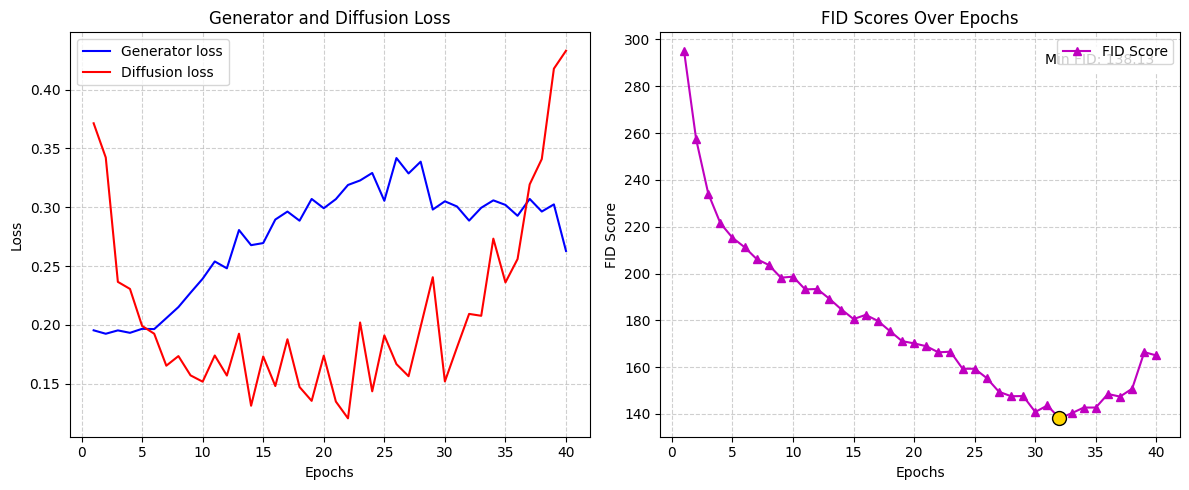

In [58]:
import json
import matplotlib.pyplot as plt

def plot_combined(loss_g, loss_d, fid_scores):
    """Fancy plot from ChatGPT."""
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # figsize to ensure plots are not too cramped

    # Plotting training and validation losses on the first subplot
    epochs = range(1, len(loss_g) + 1)
    ax1.plot(epochs, loss_g, 'b', label='Generator loss')
    ax1.plot(epochs, loss_d, 'r', label='Diffusion loss')
    ax1.set_title('Generator and Diffusion Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    # Adding a fancy grid
    ax1.grid(True, linestyle='--', alpha=0.6)
    # Adding annotations for minimum validation loss
    # min_g_loss = min(loss_g)
    # min_g_loss_epoch = loss_g.index(min_g_loss) + 1
    # ax1.scatter(min_g_loss_epoch, min_g_loss, color='green', s=50, edgecolor='black', zorder=5)  # Highlight with a larger, green dot
    # ax1.text(min_g_loss_epoch, min_g_loss * 1.15, f'Min: {min_g_loss:.4f}', fontsize=10, ha='center')

    # Plotting FID scores on the second subplot
    ax2.plot(epochs, fid_scores, 'm^-', label='FID Score')  # 'm^-' uses magenta triangles
    ax2.set_title('FID Scores Over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('FID Score')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)
    min_fid_score = min(fid_scores)
    min_fid_epoch = fid_scores.index(min_fid_score) + 1
    ax2.scatter(min_fid_epoch, min_fid_score, color='gold', s=100, edgecolor='black', zorder=5)
    ax2.text(0.95, 0.95, f'Min FID: {min_fid_score:.2f}', transform=ax2.transAxes, fontsize=10, ha='right', va='top', backgroundcolor='white')

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

def read_training_logs():
    file_path = OUTPUT_DIR / "log.txt"
    loss_g, loss_d, fid = [], [], []
    with open(file_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            loss_g.append(data["train_loss_g"])
            loss_d.append(data["train_loss_d"])
            fid.append(data["test_fid"])
    return loss_g, loss_d, fid

# Example usage:

loss_g, loss_d, test_fid = read_training_logs()
plot_combined(loss_g, loss_d, test_fid)

## Generate Samples

As we have a one-step generator model, we can generate samples for qualitative inspection.

In [68]:
from dmd.utils.array import torch_to_pillow
from dmd.modeling_utils import load_dmd_model, load_edm

def generate_samples(model):
    model.eval().to("cpu")
    batch_size = 25
    z = torch.randn((batch_size, 3, 32, 32), device="cpu")
    g_sigma = get_fixed_generator_sigma(batch_size, device="cpu")
    z = z * g_sigma[0, 0]
    with torch.no_grad():
        out = model(z, g_sigma)
    return out

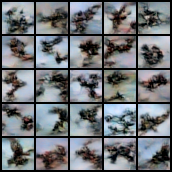

In [95]:
samples = generate_samples(generator)
pims = torch_to_pillow(samples)
image_grid(pims, 5, 5)

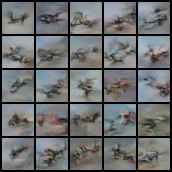

In [94]:
# load best model
# best_model = load_dmd_model(OUTPUT_DIR / "best_checkpoint.pt", "cpu")

ckp = torch.load(OUTPUT_DIR / "best_checkpoint.pt", map_location="cpu")
best_model = mu_real  # get Module object
best_model.load_state_dict(ckp["model_g"])

samples = generate_samples(best_model)
pims = torch_to_pillow(samples)
image_grid(pims, 5, 5)

## References

Karras, T., Aittala, M., Aila, T., & Laine, S. (2022). Elucidating the design space of diffusion-based generative models. Advances in Neural Information Processing Systems, 35, 26565-26577.